In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

# Visuzalizations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud


# Define global Visuzalization Rules
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# NLP data processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words

# NLP
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Data set and entry cleaning

In [2]:
df = pd.read_csv('food_delivery_apps.csv')
df.head()

,date,content,score,userName,app,platform,replyContent,repliedDate,appVersion
0,2022-10-20 17:08:18,"Being single and traveling a lot for work, all...",5,TBeck-NARC,Bolt Food,App Store,NaN,NaN,NaN
1,2022-08-19 15:56:51,App is well-designed and nice to use. Only com...,4,henhouse,Bolt Food,App Store,NaN,NaN,NaN
2,2023-07-26 09:03:32,I’ve had this payment issue for over a month n...,1,hsghdoenvskrbbd,Bolt Food,App Store,NaN,NaN,NaN
3,2022-11-22 10:00:43,Live activities would be nice instead of getti...,4,Sussy31,Bolt Food,App Store,NaN,NaN,NaN
4,2023-06-14 09:04:39,After waiting for over an hour for our food an...,1,schalas1985,Bolt Food,App Store,NaN,NaN,NaN


We can look at info() and see that there are some missing values in columns replyContent, repliedDate, appVersion

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247061 entries, 0 to 1247060
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date          1247061 non-null  object
 1   content       1247061 non-null  object
 2   score         1247061 non-null  int64 
 3   userName      1247061 non-null  object
 4   app           1247061 non-null  object
 5   platform      1247061 non-null  object
 6   replyContent  203760 non-null   object
 7   repliedDate   203760 non-null   object
 8   appVersion    973010 non-null   object
dtypes: int64(1), object(8)
memory usage: 85.6+ MB


### Data cleaning

Drop duplicates

In [4]:
df = df.drop_duplicates()

Ovierview of missing values

In [5]:
percentMissing = df.isnull().sum() * 100 / len(df)
print(percentMissing)

date             0.000000
content          0.000000
score            0.000000
userName         0.000000
app              0.000000
platform         0.000000
replyContent    83.660770
repliedDate     83.660770
appVersion      21.975687
dtype: float64


Drop unused columns

Because most reviews do not have reply, I decided not to use them. I will drop userName as well.

In [6]:
columnsToDrop = ['repliedDate', 'replyContent', 'appVersion', 'userName']
df = df.drop(columns=columnsToDrop)

Change date format

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1247060 entries, 0 to 1247060
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   date      1247060 non-null  datetime64[ns]
 1   content   1247060 non-null  object        
 2   score     1247060 non-null  int64         
 3   app       1247060 non-null  object        
 4   platform  1247060 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 57.1+ MB


In [9]:
df.head()

,date,content,score,app,platform
0,2022-10-20 17:08:18,"Being single and traveling a lot for work, all...",5,Bolt Food,App Store
1,2022-08-19 15:56:51,App is well-designed and nice to use. Only com...,4,Bolt Food,App Store
2,2023-07-26 09:03:32,I’ve had this payment issue for over a month n...,1,Bolt Food,App Store
3,2022-11-22 10:00:43,Live activities would be nice instead of getti...,4,Bolt Food,App Store
4,2023-06-14 09:04:39,After waiting for over an hour for our food an...,1,Bolt Food,App Store


### Raw data visualization

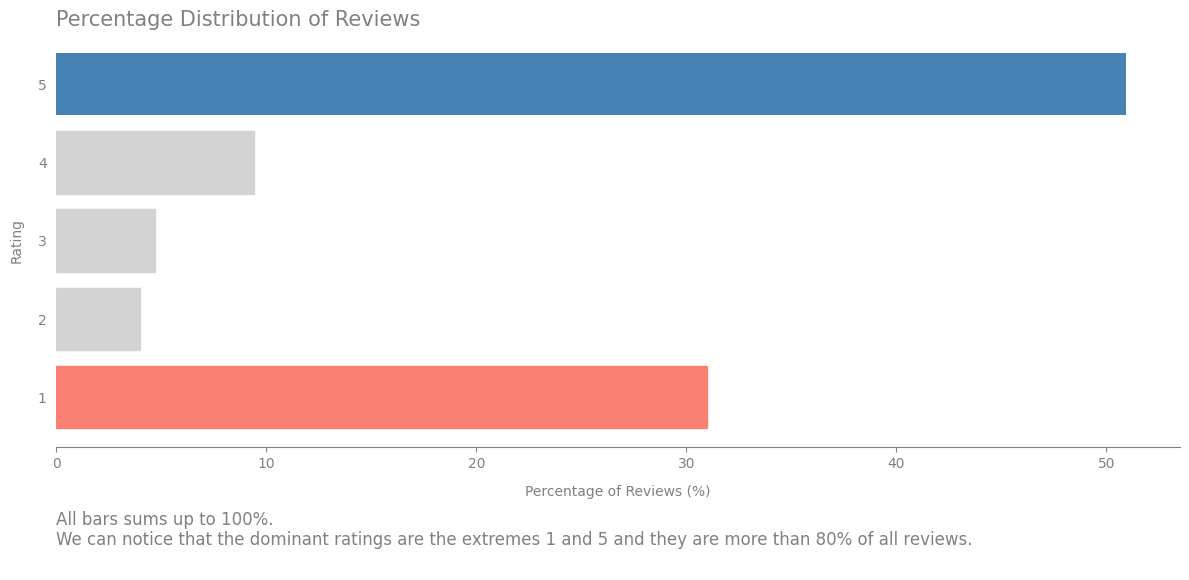

In [165]:
scoreCount = df.groupby('score').size()

# Calculate percentage distribution
totalCount = scoreCount.sum()
scorePercentage = (scoreCount / totalCount) * 100

fig, ax = plt.subplots(figsize=(12, 6))
plt.barh(scorePercentage.index, scorePercentage, color='steelblue')
bars = ax.patches

# Change color of bars
colors = ['salmon', 'lightgrey', 'lightgrey', 'lightgrey']
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Customize plot
plt.title("Percentage Distribution of Reviews",
          loc='left', fontsize=15, color='grey')
plt.xlabel("Percentage of Reviews (%)", color='grey', labelpad=10)
plt.xticks(color='grey')
plt.ylabel("Rating", color='grey', labelpad=10)
plt.yticks(color='grey')
plt.tick_params(left=False)
plt.tick_params(axis='x', color='grey')
ax.spines['bottom'].set_color('grey')

# Description
description = """
All bars sums up to 100%. \nWe can notice that the dominant ratings are the extremes 1 and 5 and they are more than 80% of all reviews.
"""
plt.text(0, -0.2, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

plt.tight_layout()
plt.show()

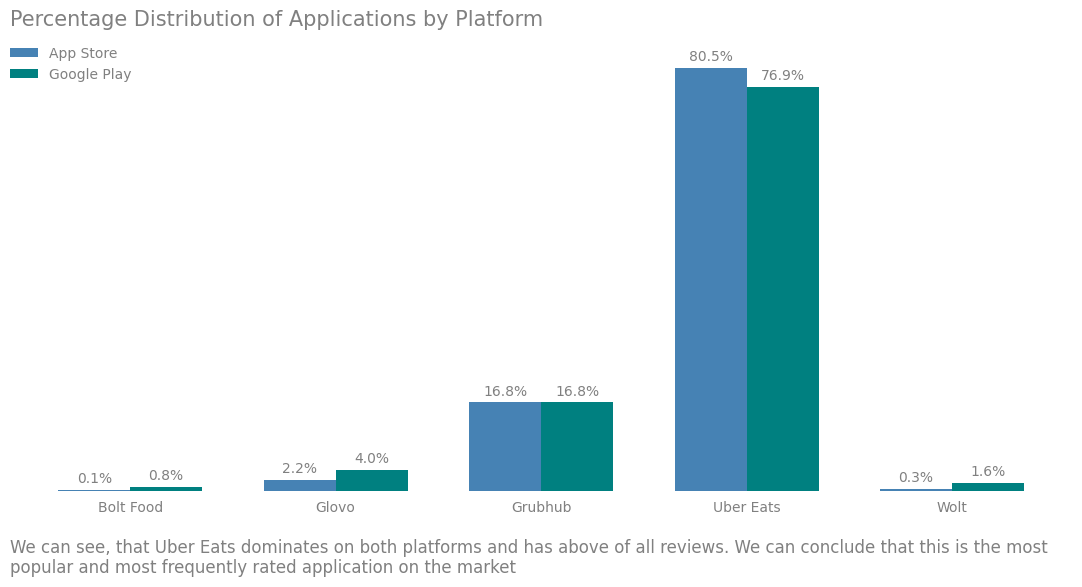

In [ ]:
platforms = df['platform'].unique()
apps = df['app'].unique()
width = 0.35  
x = np.arange(len(apps)) 
colors = ['steelblue', 'teal']

fig, ax = plt.subplots(figsize=(12, 6))

for i, platform in enumerate(platforms):
    platform_df = df[df['platform'] == platform]
    appCount = platform_df['app'].value_counts()
    appPercentage = (appCount / appCount.sum()) * 100
    appPercentage = appPercentage.reindex(apps, fill_value=0)
    ax.bar(x + i * width - width / 2, appPercentage, width, label=platform, color=colors[i])

ax.set_title('Percentage Distribution of Applications by Platform',
             loc='left', fontsize=15, color='grey', pad=15)
ax.set_xticks(x)
ax.spines['left'].set_color('none')
plt.xticks(color='grey')
plt.tick_params(bottom=False)
ax.spines['bottom'].set_color('none')
ax.set_yticks([])
ax.set_xticklabels(apps)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='gray')


bars = ax.patches
add_labels(bars)

# Description
description = """We can see, that Uber Eats dominates on both platforms and has above of all reviews. We can conclude that this is the most\npopular and most frequently rated application on the market."""
plt.text(0, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)


plt.legend(loc='upper left', frameon=False, borderpad=0.0, borderaxespad=0, labelcolor='grey')
plt.tight_layout()
plt.show()

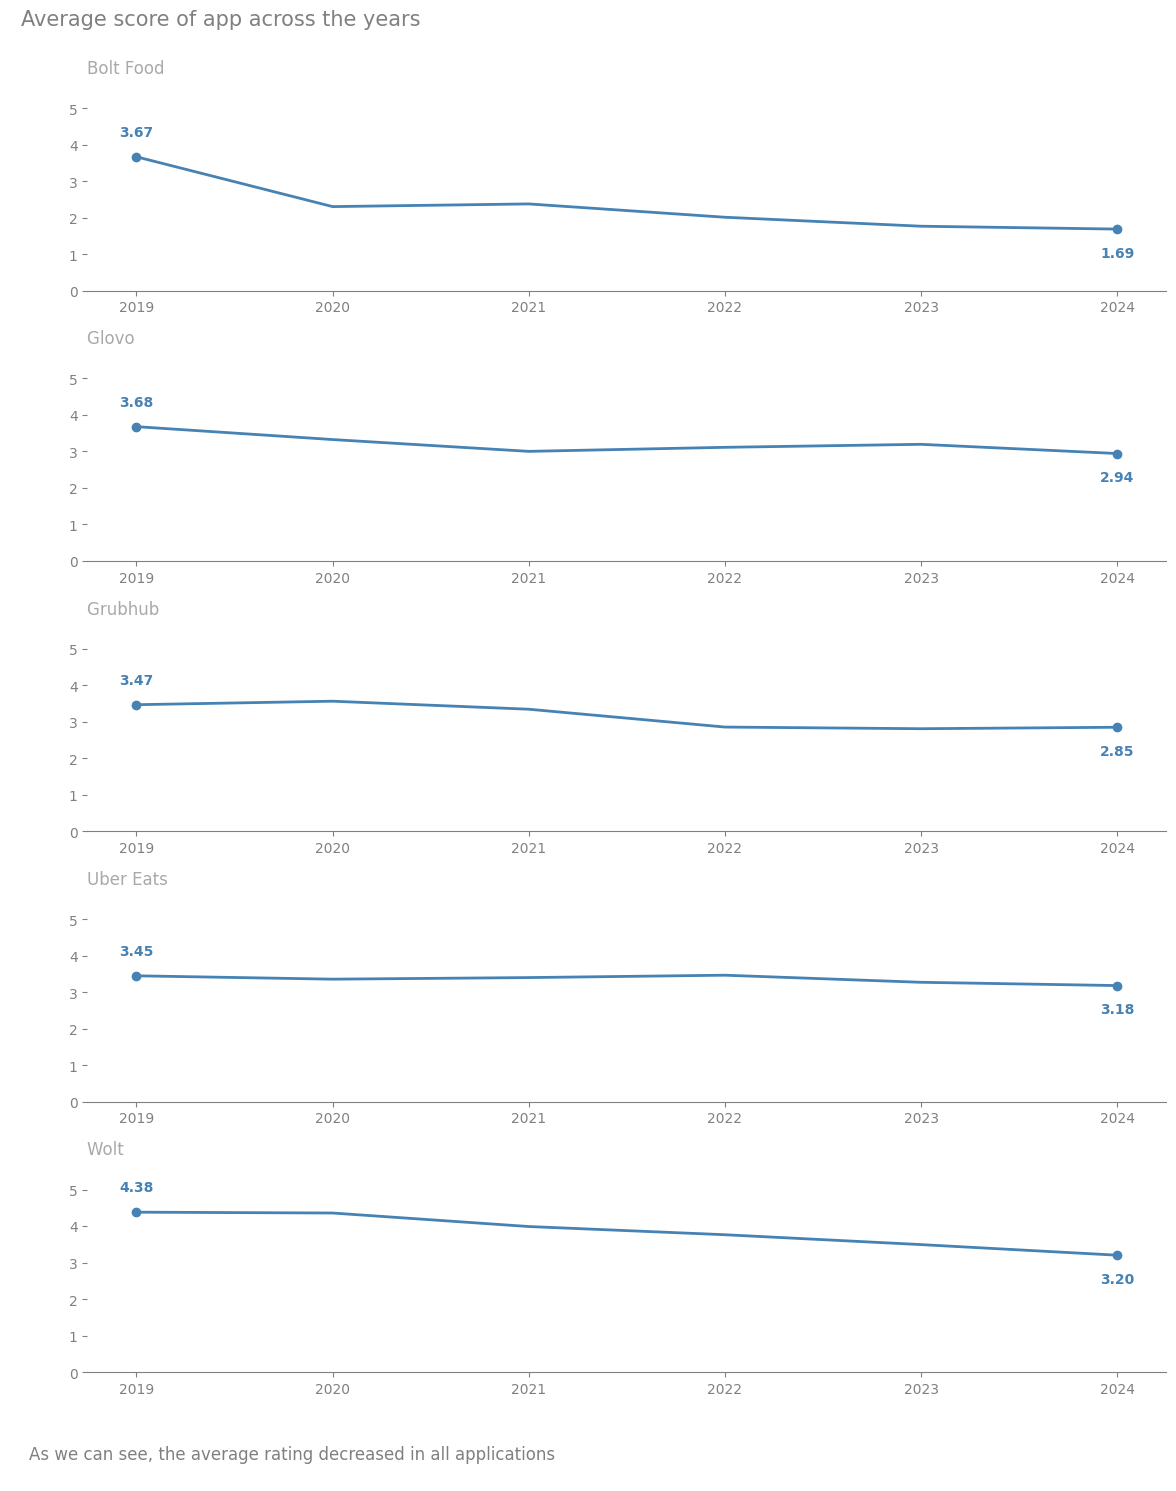

In [ ]:
fig, axes = plt.subplots(len(apps), 1, figsize=(12, len(apps) * 3))
plt.rcParams['axes.spines.left'] = True

dfFilteredByDate = df[(df['date'].dt.year >= 2019) & (df['date'].dt.year <= 2024)]

for i, app in enumerate(apps):
    appToDisplay = dfFilteredByDate[dfFilteredByDate['app'] == app]
    averageScores = appToDisplay.groupby(appToDisplay['date'].dt.year)['score'].mean()

    
    axes[i].plot(averageScores.index, averageScores, linestyle='-', label=app, color='steelblue', linewidth=2)
    axes[i].set_title(f"{app} ", fontsize=12, color='darkgrey', loc='left', pad=20)
    axes[i].set_ylim(0, 5.2)
    axes[i].spines['bottom'].set_color('grey')
    axes[i].spines['left'].set_color('grey')
    axes[i].tick_params(axis='y', colors='grey')
    axes[i].tick_params(axis='x', colors='grey')

    axes[i].scatter(averageScores.index[0], averageScores.iloc[0], color='steelblue')
    axes[i].scatter(averageScores.index[-1], averageScores.iloc[-1], color='steelblue')

    axes[i].annotate(f'{averageScores.iloc[0]:.2f}',
                     (averageScores.index[0], averageScores.iloc[0]),
                     textcoords="offset points",
                     xytext=(0, 15),
                     ha='center', color='steelblue', fontweight="bold")

    axes[i].annotate(f'{averageScores.iloc[-1]:.2f}',
                     (averageScores.index[-1], averageScores.iloc[-1]),
                     textcoords="offset points",
                     xytext=(0, -20),
                     ha='center', color='steelblue', fontweight="bold")

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.suptitle("Average score of app across the years",
             x=0.20, y=1, fontsize=15, color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')

description = """As we can see, the average rating decreased in all applications."""
plt.text(0.013, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

plt.tight_layout()
plt.show()

Correlation between length of review and its score

In [35]:
df['contentLength'] = df['content'].str.len()
correlation = df['contentLength'].corr(df['score'])
print(f"Correlation: {correlation:.2f}. We can see moderate association between length of review and score.")
df.drop(columns='contentLength')

Correlation: -0.47. We can see moderate association between length of review and score.


,date,content,score,app,platform
0,2022-10-20 17:08:18,"Being single and traveling a lot for work, all...",5,Bolt Food,App Store
1,2022-08-19 15:56:51,App is well-designed and nice to use. Only com...,4,Bolt Food,App Store
2,2023-07-26 09:03:32,I’ve had this payment issue for over a month n...,1,Bolt Food,App Store
3,2022-11-22 10:00:43,Live activities would be nice instead of getti...,4,Bolt Food,App Store
4,2023-06-14 09:04:39,After waiting for over an hour for our food an...,1,Bolt Food,App Store
...,...,...,...,...,...
1247056,2016-09-30 06:58:17,Won't accept my mobile number neither 04 or +6...,1,Wolt,Google Play
1247057,2016-09-28 10:57:18,For 10€ discount first order: EKU1,5,Wolt,Google Play
1247058,2016-09-27 17:57:46,Koodi jolla 10€ ilmaiseksi: WO08,5,Wolt,Google Play
1247059,2016-09-25 12:47:11,Account setup process is broken.,1,Wolt,Google Play


### Sampling

In [11]:
def makeSample(dataset: pd.DataFrame, size: int) -> pd.DataFrame:
    numberOfGroups = df['score'].nunique()
    sample = df.groupby('score').apply(lambda group: group.sample(n=min(len(group), size // numberOfGroups)))
    return sample.reset_index(drop=True)

In [13]:
subset = makeSample(df, 1000)

In [14]:
subset.sample(10)

,date,content,score,app,platform,contentLength
915,2019-05-18 00:19:03,I am on the phone with Customer Care as I writ...,5,Grubhub,App Store,677
507,2017-12-11 18:26:09,More choices please,3,Uber Eats,Google Play,19
739,2022-07-09 09:23:42,Good to have lots of food options available at...,4,Uber Eats,Google Play,95
950,2019-01-05 19:09:58,awesome because I can stay and get my order at...,5,Grubhub,Google Play,55
326,2020-06-12 01:31:19,Eu gostava pois encontrava muitos restaurantes...,2,Uber Eats,Google Play,315
141,2019-06-30 19:21:22,"worst service, even local delivery services ar...",1,Uber Eats,Google Play,81
750,2019-03-14 17:02:14,good for online food delivery,4,Uber Eats,Google Play,29
365,2019-02-23 05:50:48,Hi after registered my number in uber eat they...,2,Uber Eats,Google Play,134
307,2021-07-26 10:15:47,Very little recourse when things go wrong with...,2,Uber Eats,Google Play,78
439,2021-04-24 19:45:26,App barely works anymore and now if you give i...,3,Uber Eats,Google Play,108


### Data processing for NLP

Converting to lower case

In [15]:
subset['content'] = subset['content'].map(lambda word: word.lower() if isinstance(word, str) else word )

Remove non english words

In [16]:
englishWords = set(words.words())

def filterNonEnglish(review):
    if isinstance(review, str):
        splitIntoWords = review.split()
        filteredWords = [x for x in splitIntoWords if x in englishWords]
        return " ".join(filteredWords)
    return None

subset['content'] = subset['content'].apply(filterNonEnglish)

Deleting empty cells after filtering english words

In [17]:
subset['content'] = subset['content'].where(
    subset['content'].notnull() & (subset['content'].str.len() >= 1))

Removing non-word and non-whitespace characters

In [18]:
subset['content'] = subset['content'].replace(to_replace=r'[^\w\s]', value='', regex=True)

Removing digits

In [19]:
subset['content'] = subset['content'].replace(to_replace=r'\d', value='', regex=True)

Remove stopwords

In [20]:
stopWords = set(stopwords.words('english'))
def removeStopWords(text):
    return " ".join([word for word in str(text).split() if word not in stopWords])

subset["content"] = subset["content"].apply(lambda text: removeStopWords(text))

Tokenization

In [21]:
subset['content'] = subset['content'].apply(word_tokenize)

Lemmatization

In [22]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens) -> list[str]:
    def get_wordnet_pos(word) -> dict[str, str]:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tagDict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tagDict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(
        token, get_wordnet_pos(token)) for token in tokens]
    
    return lemmas

subset['content'] = subset['content'].apply(lemmatize_tokens)

In [37]:
subset.to_csv('sampleDataForPrediction.csv')

### Evaluation of models

Building model and using sample subset of dataset to reduce computational cost.

In [27]:
subset = pd.read_csv('sampleDataWithPrediction.csv')

subset['sentiment'] = subset['score'].apply(
    lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

#### BERT

In [28]:
accuracy = np.sum(subset['BertPredictedSentiment'] == subset['sentiment']) / len(subset)
precision = precision_score(subset['sentiment'], subset['BertPredictedSentiment'], average='weighted')
recall = recall_score(subset['sentiment'], subset['BertPredictedSentiment'], average='weighted')
f1 = f1_score(subset['sentiment'], subset['BertPredictedSentiment'], average='weighted')

print(f"Accuracy for BERT: {accuracy*100:.2f}%")
print(f'Precision for BERT: {precision:.2f}')
print(f'Recall for BERT: {recall:.2f}')
print(f'F1-score for BERT: {f1:.2f}')

Accuracy for BERT: 53.30%
Precision for BERT: 0.58
Recall for BERT: 0.53
F1-score for BERT: 0.53


#### Azure Language Service

In [29]:
accuracy = np.sum(subset['AzurePredictedSentiment'] ==
                  subset['sentiment']) / len(subset)
precision = precision_score(
    subset['sentiment'], subset['AzurePredictedSentiment'], average='weighted')
recall = recall_score(subset['sentiment'],
                      subset['AzurePredictedSentiment'], average='weighted')
f1 = f1_score(subset['sentiment'],
              subset['AzurePredictedSentiment'], average='weighted')

print(f"Accuracy for Azure: {accuracy*100:.2f}%")
print(f'Precision for Azure: {precision:.2f}')
print(f'Recall for Azure: {recall:.2f}')
print(f'F1-score for Azure: {f1:.2f}')

Accuracy for Azure: 39.30%
Precision for Azure: 0.65
Recall for Azure: 0.39
F1-score for Azure: 0.42


### Visualization of ML prediction

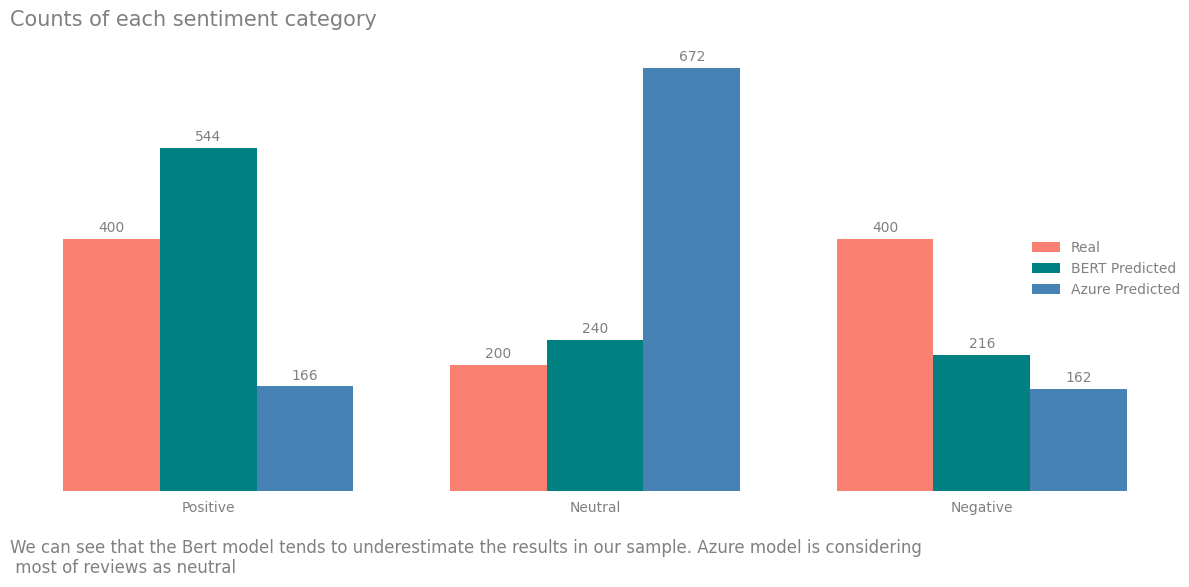

In [30]:
trueCounts = subset['sentiment'].value_counts().reindex(
    ['positive', 'neutral', 'negative'])
bertCounts = subset['BertPredictedSentiment'].value_counts().reindex(
    ['positive', 'neutral', 'negative'])
azureCounts = subset['AzurePredictedSentiment'].value_counts().reindex(
    ['positive', 'neutral', 'negative'])

index = np.arange(len(trueCounts))
width = 0.25  # Adjust bar width to fit three groups
colors = ['salmon', 'teal', 'steelblue']
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars
plt.bar(index - width, trueCounts, width, label='Real', color=colors[0])
plt.bar(index, bertCounts, width, label='BERT Predicted', color=colors[1])
plt.bar(index + width, azureCounts, width,
        label='Azure Predicted', color=colors[2])

# Title and labels
plt.title('Counts of each sentiment category',
          loc='left', fontsize=15, color='grey', pad=15)
plt.xticks(index, ('Positive', 'Neutral', 'Negative'), color='grey')
plt.yticks([])
plt.tick_params(bottom=False)
ax.spines['bottom'].set_color('None')

# Add annotations


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='gray')


bars = ax.patches
add_labels(bars)

# Description
description = """We can see that the Bert model tends to underestimate the results in our sample. Azure model is considering
 most of reviews as neutral"""
plt.text(0, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

# Legend
plt.legend(frameon=False, loc='right', borderpad=0.0,
           borderaxespad=0, labelcolor='grey')
plt.tight_layout()
plt.show()

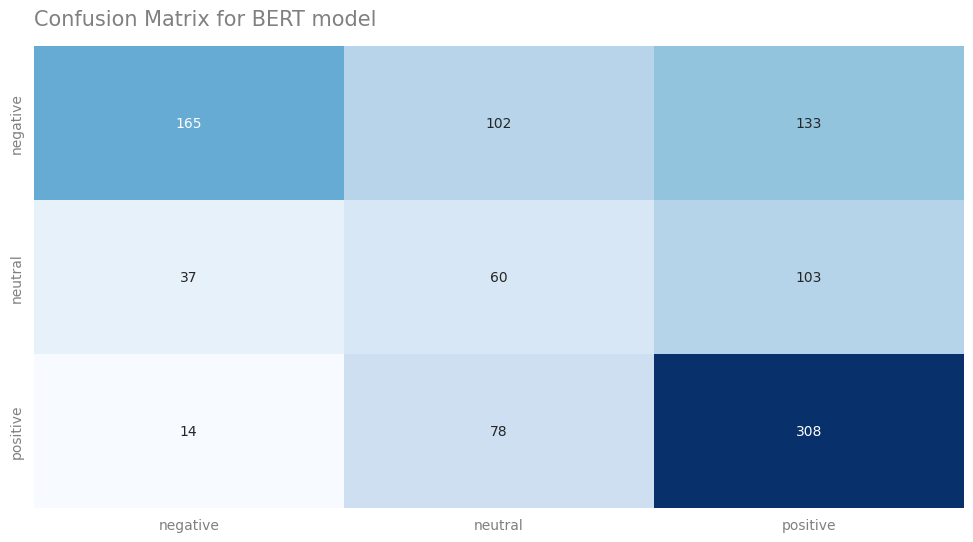

In [31]:
labelMapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

cm = confusion_matrix(subset['sentiment'], subset['BertPredictedSentiment'])

labels = [labelMapping[i] for i in sorted(labelMapping.keys())]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix for BERT model', loc='left', fontsize=15, color='grey', pad=15)
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.show()

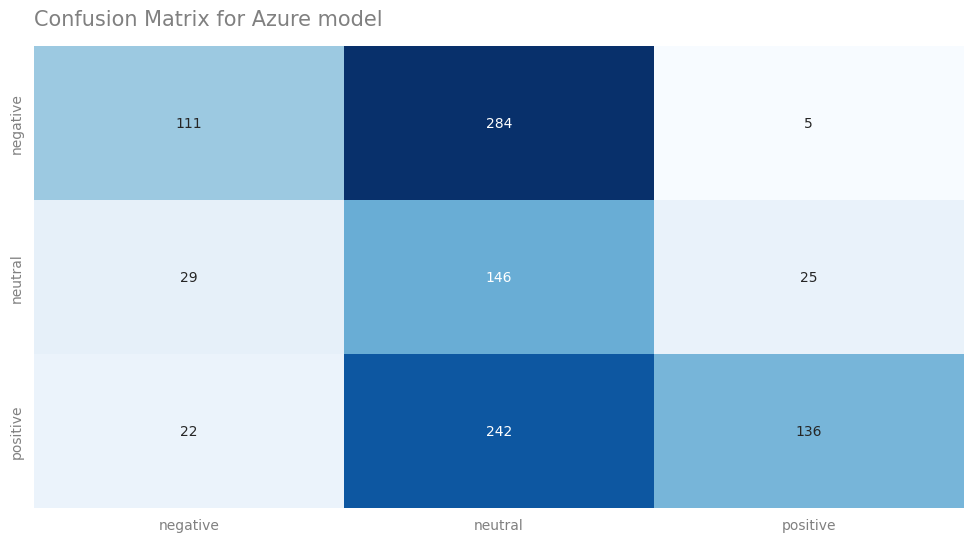

In [32]:
labelMapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

cm = confusion_matrix(subset['sentiment'], subset['AzurePredictedSentiment'])

labels = [labelMapping[i] for i in sorted(labelMapping.keys())]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix for Azure model',
          loc='left', fontsize=15, color='grey', pad=15)
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.show()